<a href="https://colab.research.google.com/github/alexandrgsv/stock_prediction_models/blob/main/%22MMVB_LSTM_ub_lb_CWB_pareto_front_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K


In [2]:
# Load the data
#data = pd.read_csv('https://drive.google.com/uc?id=18RjIb6w6OXLPeKYJ-UJKUNtmY71RpP5D', header=0, usecols=['<DATE>', '<CLOSE>'], date_parser=True)
data = pd.read_csv('https://drive.google.com/uc?id=18RjIb6w6OXLPeKYJ-UJKUNtmY71RpP5D',
                   header=0, 
                   usecols=['<DATE>', '<CLOSE>'], 
                   parse_dates=['<DATE>'], 
                   date_parser=lambda x: pd.to_datetime(x, format='%d/%m/%y'))

df = data[['<DATE>', '<CLOSE>']].copy()

In [3]:
df = df.sort_values('<DATE>')
df = df.reset_index(drop=True)
#df = df.set_index('<DATE>').sort_index()



In [4]:
# Split the data into training and test sets
train_size = int(len(df) * 0.8)
train = df[:train_size]
#test = df[train_size-window_size:]
test = df[train_size:]

In [5]:
# Scale the data
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train['<CLOSE>'].values.reshape(-1, 1))
test_scaled = scaler.transform(test['<CLOSE>'].values.reshape(-1, 1))


In [6]:

def picp(y_true, y_pred):
    lower = y_pred[..., 1]
    upper = y_pred[..., 0]
    real_l = y_true[..., 1]
    real_u = y_true[..., 0]
    return np.mean(np.logical_and(real_u <= upper, real_l >= lower))
 

In [7]:
import tensorflow_probability as tfp

def coverage_loss(y_true, y_pred, width=0.1):
    q = (1 - width) / 2
    e = y_true - y_pred
    coverage = K.cast(K.abs(e) < tfp.stats.percentile(K.abs(e), q + width * 100), dtype='float32')
    coverage_error = K.mean((1 - coverage) * K.abs(e))
    prediction_error = K.mean(coverage * K.abs(e))
    return coverage_error + prediction_error

In [10]:
# Define sliding window size and stride length
window_size = 1
stride_length = 1
forecast_horizon = 10

# Function to generate sliding windows for both training and test sets
def generate_sliding_windows(data, window_size, stride_length):
    X = []
    y_upper = []
    y_lower = []
    for i in range(0, len(data) - window_size - forecast_horizon + 1, stride_length):
        window = data[i:i+window_size]
        upper_bounds = [[window.mean() + j*window.std() for j in range(1, forecast_horizon+1)]] #* forecast_horizon
        lower_bounds = [[window.mean() - j*window.std() for j in range(1, forecast_horizon+1)]] #* forecast_horizon
        X.append(window)
        y_upper.append(upper_bounds)
        y_lower.append(lower_bounds)
    return np.array(X), np.array(y_upper).reshape((-1, forecast_horizon)), np.array(y_lower).reshape((-1, forecast_horizon))

# Generate sliding windows for both training and test sets
X_train, y_train_upper, y_train_lower = generate_sliding_windows(train_scaled, window_size, stride_length)
X_test, y_test_upper, y_test_lower = generate_sliding_windows(test_scaled, window_size, stride_length)


In [16]:
# Split train data into two complementary parts
split_index = len(X_train) // 2
X1_train, X2_train = X_train[:split_index], X_train[split_index:]
y1_train_upper, y2_train_upper = y_train_upper[:split_index], y_train_upper[split_index:]
y1_train_lower, y2_train_lower = y_train_lower[:split_index], y_train_lower[split_index:]


In [25]:
# Define the model
model = Sequential([
    LSTM(units=5, return_sequences=False, input_shape=(window_size, 1)),
    Dense(units=forecast_horizon*2)
])


In [26]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='loss', patience=5, mode='min', verbose=0)


In [28]:
def fitness_function(params, X_train, y_train_lower, y_train_upper, X_val, y_val_lower, y_val_upper):
  lr = max(1e-5, abs(params[0]))
  batch_size = max(8, abs(int(params[1])))
  epochs = max(1, abs(int(params[2])))
  print("       Particle position is ", lr, " ", batch_size, " ", epochs, " (lr, batch_size, epochs)")
  model.compile(optimizer=Adam(learning_rate=lr), loss=coverage_loss)
  # Train the model
  history = model.fit(X_train.reshape((X_train.shape[0], X_train.shape[1], 1)), np.column_stack((y_train_upper, y_train_lower)), epochs=epochs, batch_size=batch_size, callbacks = [early_stop], verbose = 0)
  #return history.history['val_loss'][-1]
  return model.evaluate(X_val.reshape((X_val.shape[0], X_val.shape[1], 1)), np.column_stack((y_val_upper, y_val_lower)), batch_size=batch_size, verbose = 0)

In [29]:
import random

# Step 1:

# Set the PSO parameters
lb = [1e-5, 16, 20]  # Lower bounds for learning rate, batch size, and epochs
ub = [1e-2, 32, 100]  # Upper bounds for learning rate, batch size, and epochs

# Number of particles and iterations
n_particles = 5
n_iterations = 2
n_dimensions = 3


# Step 2: Initialize particle swarm
class Particle:
    def __init__(self):
        self.position = np.random.uniform(low=lb, high=ub, size=(n_dimensions))
        self.velocity = np.random.uniform(low=-1*(np.array(ub)-np.array(lb)), high=np.array(ub)-np.array(lb), size=(n_dimensions))
        self.pbest_position = self.position.copy()
        self.pbest_fitness = None
        self.domination_count = 0
        self.dominated_solutions = []
        self.fitness = (0,0)

swarm = [Particle() for _ in range(n_particles)]
gbest_position = None
gbest_fitness = None

for p in swarm:
  p.fitness = (10,10)

# Step 3-6: Evaluate, update, and iterate
for i in range(n_iterations):
    print("Iteration number ", i+1, " of ", n_iterations)
    current_p = 1
    for p in swarm:
        print("     Particle number ", current_p, " of ", n_particles)
        current_p = current_p + 1
        # Evaluate fitness
        fitness1 = fitness_function(p.position, X1_train, y1_train_lower, y1_train_upper, X_test, y_test_lower, y_test_upper)
        fitness2 = fitness_function(p.position, X2_train, y2_train_lower, y2_train_upper, X_test, y_test_lower, y_test_upper)
        p.fitness = (fitness1, fitness2)

        # Update personal best
        if p.pbest_fitness is None or p.fitness < p.pbest_fitness:
            p.pbest_position = p.position.copy()
            p.pbest_fitness = p.fitness

        # Update global best
        if gbest_fitness is None or p.fitness < gbest_fitness:
            gbest_position = p.position.copy()
            gbest_fitness = p.fitness

        
        # Update velocity and position
        for j in range(n_dimensions):
            rp = random.uniform(0, 1)
            rg = random.uniform(0, 1)
            vel_cognitive = 2 * rp * (p.pbest_position[j] - p.position[j])
            vel_social = 2 * rg * (gbest_position[j] - p.position[j])
            p.velocity[j] = 0.5 * p.velocity[j] + vel_cognitive + vel_social
            p.position[j] += p.velocity[j]
    
   # Calculate domination count and dominated solutions

    for p in swarm:
      p.domination_count = 0
      p.dominated_solutions = []
      for q in swarm:
        if all(p.fitness[i] < q.fitness[i] for i in range(len(p.fitness))):
          p.dominated_solutions.append(q)
        elif all(q.fitness[i] < p.fitness[i] for i in range(len(q.fitness))):
          p.domination_count += 1

    # Step 7: Select non-dominated solutions
    pareto_front = []
    dominated_solutions = []
    for p in swarm:
        if p.domination_count == 0:
            pareto_front.append(p)
        else:
           dominated_solutions.append(p)

# Print Pareto front
for p in pareto_front:
    print(p.position, p.fitness)

Iteration number  1  of  2
     Particle number  1  of  5
       Particle position is  0.005994425076842192   21   97  (lr, batch_size, epochs)
       Particle position is  0.005994425076842192   21   97  (lr, batch_size, epochs)
     Particle number  2  of  5
       Particle position is  0.005154971437013191   20   72  (lr, batch_size, epochs)
       Particle position is  0.005154971437013191   20   72  (lr, batch_size, epochs)
     Particle number  3  of  5
       Particle position is  0.0030374083007416973   30   66  (lr, batch_size, epochs)
       Particle position is  0.0030374083007416973   30   66  (lr, batch_size, epochs)
     Particle number  4  of  5
       Particle position is  0.00507398657778957   19   84  (lr, batch_size, epochs)
       Particle position is  0.00507398657778957   19   84  (lr, batch_size, epochs)
     Particle number  5  of  5
       Particle position is  0.0035590616699247672   22   97  (lr, batch_size, epochs)
       Particle position is  0.003559061669

In [30]:
pareto_front_fitness = []
dominated_solutions_fitness = []

for p in pareto_front:
    pareto_front_fitness.append(p.fitness)

for q in dominated_solutions:
    dominated_solutions_fitness.append(q.fitness)

print(pareto_front_fitness)
print(dominated_solutions_fitness)

[(0.03923175856471062, 0.018100831657648087), (0.03222711384296417, 0.01910576969385147)]
[(0.06681765615940094, 0.024499837309122086), (0.058374565094709396, 0.020810965448617935), (0.04559486731886864, 0.01926988922059536)]


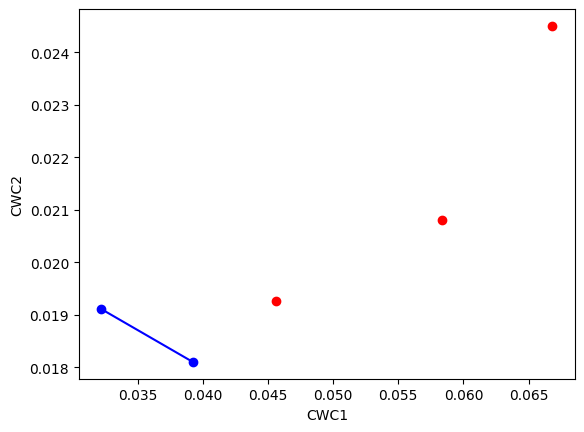

In [31]:
# sort the pareto front by x-coordinate
pareto_front_fitness.sort(key=lambda p: p[0])

# extract the sorted x and y coordinates from the tuples
x = [p[0] for p in pareto_front_fitness]
y = [p[1] for p in pareto_front_fitness]

# extract the sorted x and y coordinates from the tuples of dominated solutions
x_dom = [p[0] for p in dominated_solutions_fitness]
y_dom = [p[1] for p in dominated_solutions_fitness]

# create a line plot with dots at each point on the x and y coordinates
plt.plot(x, y, 'o-', color='blue')
plt.plot(x_dom, y_dom, 'o', color='red', linestyle='None')

# set the labels for the x and y axes
plt.xlabel('CWC1')
plt.ylabel('CWC2')

# show the plot
plt.show()

In [36]:
#compile the model for the chosen Pareto point
  
params = pareto_front[0].position

lr = abs(params[0])
batch_size = abs(int(params[1]))
epochs = abs(int(params[2]))

model.compile(optimizer=Adam(learning_rate=lr), loss=coverage_loss)
# Train the model
history = model.fit(X_train.reshape((X_train.shape[0], X_train.shape[1], 1)), np.column_stack((y_train_upper, y_train_lower)), epochs=epochs, batch_size=batch_size, callbacks = [early_stop], verbose = 1)

Epoch 1/100
154/154 [==============================] - 3s 3ms/step - loss: 0.0014
Epoch 2/100
154/154 [==============================] - 1s 4ms/step - loss: 7.9014e-04
Epoch 3/100
154/154 [==============================] - 0s 3ms/step - loss: 8.3877e-04
Epoch 4/100
154/154 [==============================] - 0s 3ms/step - loss: 8.6229e-04
Epoch 5/100
154/154 [==============================] - 1s 3ms/step - loss: 7.2033e-04
Epoch 6/100
154/154 [==============================] - 1s 6ms/step - loss: 8.2815e-04
Epoch 7/100
154/154 [==============================] - 1s 4ms/step - loss: 8.0101e-04
Epoch 8/100
154/154 [==============================] - 1s 3ms/step - loss: 8.0719e-04
Epoch 9/100
154/154 [==============================] - 0s 3ms/step - loss: 9.5373e-04
Epoch 10/100
154/154 [==============================] - 0s 2ms/step - loss: 8.0460e-04


In [37]:
# Assuming you have already trained the model and have X_test and y_test data, and a scaler object named "scaler"
y_pred = model.predict(X_test.reshape((X_test.shape[0], X_test.shape[1], 1)))
# The output will be a numpy array with shape (num_samples, 2)
# where the first column contains upper bound predictions and the second column contains lower bound predictions

# Inverse transform the predicted values and actual values
y_pred_actual = scaler.inverse_transform(y_pred)
y_test_actual = scaler.inverse_transform(np.column_stack((y_test_upper, y_test_lower)))

# You can then use these actual values for further analysis or evaluation of the model's performance

31/31 [==============================] - 1s 3ms/step


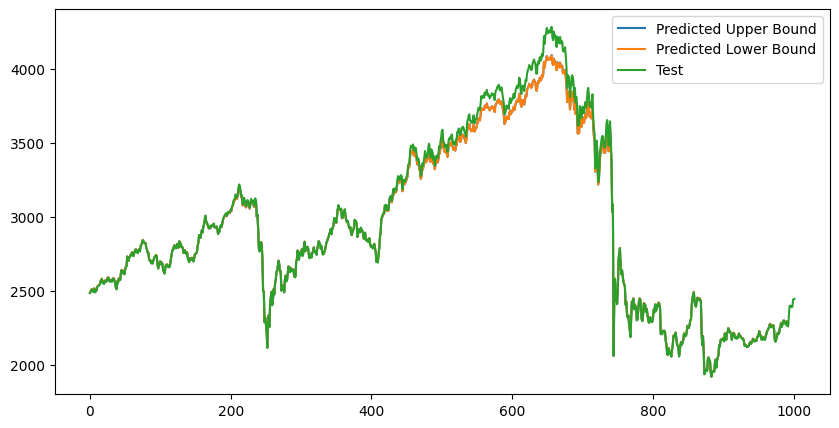

In [38]:
# Plot predicted vs actual intervals with filling between lower and upper bounds

plt.figure(figsize=(10, 5))
plt.plot(y_pred_actual[:, 0], label='Predicted Upper Bound')
plt.plot(y_pred_actual[:, 1], label='Predicted Lower Bound')
#plt.plot(y_test_actual[:, 0], label='Actual Upper Bound')
#plt.plot(y_test_actual[:, 1], label='Actual Lower Bound')
plt.plot(test['<CLOSE>'].values.reshape(-1, 1), label = 'Test')
plt.fill_between(range(len(y_test_actual)), y_pred_actual[:, 0], y_pred_actual[:, 1], alpha=0.2)
plt.legend()
plt.show()
